# Step0: Import packages and preparing the data
Carefully make sure you `data_dir` can get the right RESP and HEA data!

In [1]:
!pip install wfdb
import os
import numpy as np
import matplotlib.pyplot as plt
import wfdb # read Physionet/picsdb file format
from picsdb import load_waveforms
from wfdb import processing
from numba import jit
data_dir = "E:\\jupter-repos\\picsdb\\1.0.0"
print(picsdb)

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


In [59]:
# Initial Inspect
L = os.listdir(data_dir)
for l in L:
    print(l)


ANNOTATORS
infant10_ecg.atr
infant10_ecg.dat
infant10_ecg.hea
infant10_ecg.qrsc
infant10_resp.dat
infant10_resp.hea
infant10_resp.resp
infant1_ecg.atr
infant1_ecg.dat
infant1_ecg.hea
infant1_ecg.qrsc
infant1_resp.dat
infant1_resp.hea
infant1_resp.resp
infant2_ecg.atr
infant2_ecg.dat
infant2_ecg.hea
infant2_ecg.qrsc
infant2_resp.dat
infant2_resp.hea
infant2_resp.resp
infant3_ecg.atr
infant3_ecg.dat
infant3_ecg.hea
infant3_ecg.qrsc
infant3_resp.dat
infant3_resp.hea
infant3_resp.resp
infant4_ecg.atr
infant4_ecg.dat
infant4_ecg.hea
infant4_ecg.qrsc
infant4_resp.dat
infant4_resp.hea
infant4_resp.resp
infant5_ecg.atr
infant5_ecg.dat
infant5_ecg.hea
infant5_ecg.qrsc
infant5_resp.dat
infant5_resp.hea
infant5_resp.resp
infant6_ecg.atr
infant6_ecg.dat
infant6_ecg.hea
infant6_ecg.qrsc
infant6_resp.dat
infant6_resp.hea
infant6_resp.resp
infant7_ecg.atr
infant7_ecg.dat
infant7_ecg.hea
infant7_ecg.qrsc
infant7_resp.dat
infant7_resp.hea
infant7_resp.resp
infant8_ecg.atr
infant8_ecg.dat
infant8_ecg.he

In [60]:
# Manual file selection
file_index = 3
file_ecg = os.path.join(data_dir, f"infant{file_index:d}_ecg")
file_resp = os.path.join(data_dir, f"infant{file_index:d}_resp")
print("Loading ECG file : ", file_ecg)
print("Loading RESP file: ", file_resp)
record_ecg = wfdb.rdrecord(file_ecg)
record_resp = wfdb.rdrecord(file_resp)

Loading ECG file :  E:\jupter-repos\picsdb\1.0.0\infant3_ecg
Loading RESP file:  E:\jupter-repos\picsdb\1.0.0\infant3_resp


In [61]:
d_ecg = record_ecg.__dict__
d_resp = record_resp.__dict__
print(d_ecg)

{'record_name': 'infant3_ecg', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 78684614, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['II'], 'p_signal': array([[ 0.09467079],
       [ 0.09993028],
       [ 0.09467079],
       ...,
       [-0.83976496],
       [-0.91427437],
       [-0.94407814]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['infant3_ecg.dat'], 'fmt': ['16'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [1140.7954], 'baseline': [11394], 'units': ['mV'], 'adc_res': [0], 'adc_zero': [0], 'init_value': [11502], 'checksum': [22904], 'block_size': [0]}


In [62]:
print("ECG record: ", d_ecg['record_name'])
print("number of signals: ", d_ecg['n_sig'])
print("sampling frequency: ", d_ecg['fs'], "Hz")
print("Number of samples: ", d_ecg['sig_len'])
print("Signal name: ", d_ecg['sig_name'])

ECG record:  infant3_ecg
number of signals:  1
sampling frequency:  500 Hz
Number of samples:  78684614
Signal name:  ['II']


In [63]:
print("RESP record: ", d_resp['record_name'])
print("number of signals: ", d_resp['n_sig'])
print("sampling frequency: ", d_resp['fs'], "Hz")
print("Number of samples: ", d_resp['sig_len'])
print("Signal name: ", d_resp['sig_name'])

RESP record:  infant3_resp
number of signals:  1
sampling frequency:  50 Hz
Number of samples:  7868296
Signal name:  ['RESP']


In [64]:
# Next, extract the ECG/RESP data arrays and convert them into 1-dimensional arrays using ravel:
x_ecg = d_ecg['p_signal'].ravel()
print("Number of ECG samples: ", x_ecg.shape[0], " data type: ", x_ecg.dtype)

Number of ECG samples:  78684614  data type:  float64


In [65]:
x_resp = d_resp['p_signal'].ravel()
print("Number of RESP samples: ", x_resp.shape[0], " data type: ", x_resp.dtype)

Number of RESP samples:  7868296  data type:  float64


In [66]:
# interval = 1/frequency
fs_ecg = d_ecg['fs'] # ECG sampling rate in Hz
dt_ecg = 1/fs_ecg # ECG sampling interval in sec.
fs_resp = d_resp['fs'] # RESP sampling rate in Hz
dt_resp = 1/fs_resp # RESP sampling interval in sec.
print("ECG sampling frequency: ", fs_ecg, " Hz")
print("ECG sampling interval dt = ", dt_ecg, " sec.")
print("RESP sampling frequency: ", fs_resp, " Hz")
print("RESP sampling interval dt = ", dt_resp, " sec.")

ECG sampling frequency:  500  Hz
ECG sampling interval dt =  0.002  sec.
RESP sampling frequency:  50  Hz
RESP sampling interval dt =  0.02  sec.


In [67]:
# Select time window manually
# set display time limits manually, recordings are many hours, millions of data points...
#t0_sec, t1_sec = 90620, 90640 # seconds

# ...or, if you want to look at the whole recording:
t0_sec, t1_sec = 0, x_resp.shape[0]*dt_resp # seconds, based on RESP signal

# convert seconds to samples, respect different sampling rates for ECG and RESP signals
t0_sample_ecg = round(t0_sec * fs_ecg)
t1_sample_ecg = round(t1_sec * fs_ecg)
t0_sample_resp = round(t0_sec * fs_resp)
t1_sample_resp = round(t1_sec * fs_resp)

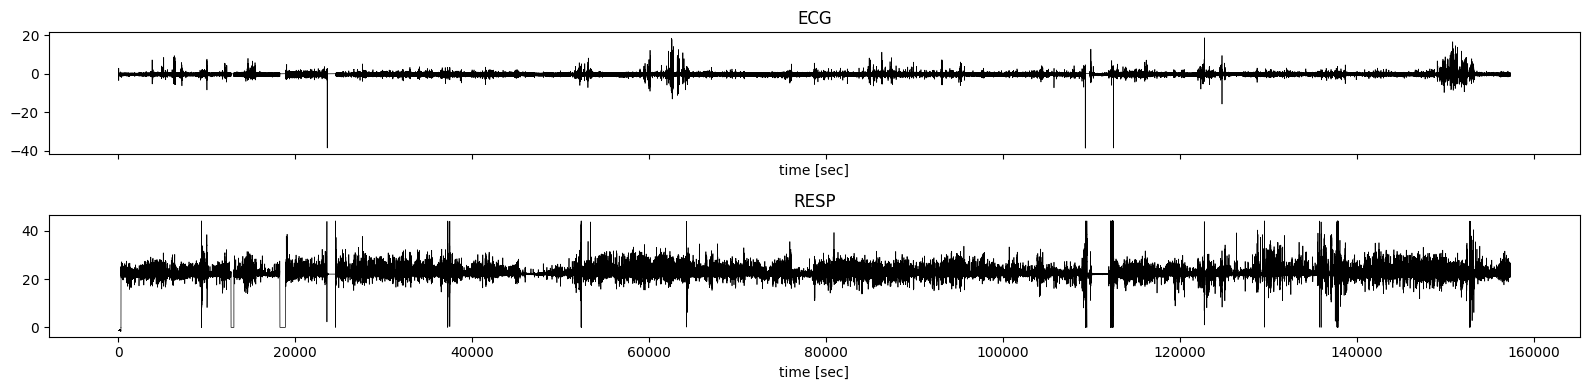

In [68]:
# plot 
# this tells the notebook to open figures outside of the notebook
#%matplotlib qt
%matplotlib inline

time_ecg = np.arange(x_ecg.shape[0])*dt_ecg # ECG time axis
time_resp = np.arange(x_resp.shape[0])*dt_resp # RESP time axis

fig1, ax = plt.subplots(2, 1, figsize=(16,4), sharex=True)
ax[0].plot(time_ecg[t0_sample_ecg:t1_sample_ecg], x_ecg[t0_sample_ecg:t1_sample_ecg], '-k', lw=0.5)
ax[1].plot(time_resp[t0_sample_resp:t1_sample_resp], x_resp[t0_sample_resp:t1_sample_resp], '-k', lw=0.5)
ax[0].set_xlabel("time [sec]")
ax[1].set_xlabel("time [sec]")
ax[0].set_title("ECG")
ax[1].set_title("RESP")
plt.tight_layout()
plt.show()

## PART2 Selection of sample segments
Use the manually selected segment borders (in seconds) that were identified
**Can add a random function here** 
List item
List item
visually using picsdb1_inspect.ipynb: 

In [69]:
# A
segments = {}
for i in range(10):
    key = f"infant{i+1:d}"
    segments[key] = []
segments['infant1'] = [(5110,5355)]
segments['infant2'] = [(3955,3960)]
segments['infant3'] = [(5575,13940)]
segments['infant4'] = [(5860,12980)]
segments['infant5'] = [(103750,147350)] #FINAL
segments['infant6'] = [(7130,13670)]
segments['infant7'] = [(5060,13630)]
segments['infant8'] = [(4880,14570)]
segments['infant9'] = [(5940,12580)]
segments['infant10'] = [(3225,14710)]

## PART3 Select thresholds for peak detection for each sample
Part 3 will be re-ran every segement. The final thresholds selected will be recorded in columns D to K of 'Preterm Infant Data Input Settings Blank' excel spreadsheet.

Our complete and filled out excel spreadsheet is titled 'Preterm Infant Data Input Settings'. Refer to that if wanting to produce our exact results.

### Step One: Select segement to work with

Select a segment to work with by entering in an Infant number/ file_index (1 to 10) and a segement number

file_index = 2 # 1...10, loads data from infant1 ... infant10 segment_index = 0

In [70]:
file_index = 2 # 1...10, loads data from infant1 ... infant10
segment_index = 0 # 0,...

## Step two: Import all the revelent data for that segement
Similar to part 1, the data will be imported but only part of the signal. Part 2, Step Two created a dictionary that will be used so the correct segment of time is selected from the overall signal and Part 3, Step One determines which segment it is.

In [76]:
# Data Import
x_ecg_full, x_resp_full, fs_ecg, fs_resp = load_waveforms(data_dir, file_index)
dt_ecg = 1/fs_ecg # ECG sampling interval in sec.
dt_resp = 1/fs_resp # RESP sampling interval in sec.
print("ECG sampling interval dt = ", dt_ecg, " sec.")
print("RESP sampling interval dt = ", dt_resp, " sec.")

NameError: name 'load_waveforms' is not defined